In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

### Quote Data preparation for training Hidden Markov Models on High-Frequency Quote Data

- Data preprocessing and cleaning
- Parsing observation vectors from raw data
- Labelling hidden states within training dataset

In [7]:
quotes=pd.read_csv('data/cleaned_quotes.csv',index_col=0)


simple_quotes=quotes[['Exchange','Symbol','Bid_Price','Bid_Size','Offer_Price','Offer_Size']].copy()
simple_quotes=simple_quotes[simple_quotes.index<"2020-01-03"]

simple_quotes['OB_IB']=simple_quotes['Offer_Size']/simple_quotes['Bid_Size']
simple_quotes['spread']=simple_quotes['Offer_Price']-simple_quotes['Bid_Price']
simple_quotes

C:\Users\jbohn\AppData\Local\Temp\ipykernel_30048\1377133329.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  quotes=pd.read_csv('data/cleaned_quotes.csv',index_col=0)


,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,OB_IB,spread
2020-01-02 09:30:00.134062,P,AAPL,296.09,1.0,296.29,1.0,1.000000,0.20
2020-01-02 09:30:00.134336,K,AAPL,296.21,1.0,296.39,1.0,1.000000,0.18
2020-01-02 09:30:00.134532,K,AAPL,296.10,1.0,296.36,2.0,2.000000,0.26
2020-01-02 09:30:00.136081,K,AAPL,296.10,1.0,296.29,1.0,1.000000,0.19
2020-01-02 09:30:00.234474,K,AAPL,296.11,1.0,296.39,1.0,1.000000,0.28
...,...,...,...,...,...,...,...,...
2020-01-02 19:59:43.952528,P,AAPL,300.79,2.0,301.34,1.0,0.500000,0.55
2020-01-02 19:59:52.610437,P,AAPL,300.79,2.0,301.19,1.0,0.500000,0.40
2020-01-02 19:59:52.611152,P,AAPL,300.79,2.0,301.34,1.0,0.500000,0.55
2020-01-02 19:59:52.611817,Q,AAPL,301.19,1.0,302.00,6.0,6.000000,0.81


### Label our States

- Spread Tightens or Widens compared to last BBO
- Top of Book Relation to last BBO

In [8]:

simple_quotes['last_spread']=simple_quotes['spread'].shift(1)

#label state as 1 or -1 based on widen or tighten
def label_spread(x):
    if x['spread']>x['last_spread']:
        # spread widens
        return 1
    elif x['spread']<x['last_spread']:
        # spread tightens 
        return -1
    else:
        return 0
simple_quotes['spread_state']=simple_quotes.apply(lambda x:label_spread(x),axis=1)
simple_quotes=simple_quotes.drop(columns=['last_spread'])



In [9]:
simple_quotes

,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,OB_IB,spread,spread_state
2020-01-02 09:30:00.134062,P,AAPL,296.09,1.0,296.29,1.0,1.000000,0.20,0
2020-01-02 09:30:00.134336,K,AAPL,296.21,1.0,296.39,1.0,1.000000,0.18,-1
2020-01-02 09:30:00.134532,K,AAPL,296.10,1.0,296.36,2.0,2.000000,0.26,1
2020-01-02 09:30:00.136081,K,AAPL,296.10,1.0,296.29,1.0,1.000000,0.19,-1
2020-01-02 09:30:00.234474,K,AAPL,296.11,1.0,296.39,1.0,1.000000,0.28,1
...,...,...,...,...,...,...,...,...,...
2020-01-02 19:59:43.952528,P,AAPL,300.79,2.0,301.34,1.0,0.500000,0.55,1
2020-01-02 19:59:52.610437,P,AAPL,300.79,2.0,301.19,1.0,0.500000,0.40,-1
2020-01-02 19:59:52.611152,P,AAPL,300.79,2.0,301.34,1.0,0.500000,0.55,1
2020-01-02 19:59:52.611817,Q,AAPL,301.19,1.0,302.00,6.0,6.000000,0.81,1


### Analysis of Features

- Observations are a discrete continuous vector within R^4
- Hidden States are binary (1, -1)

In [43]:
features=simple_quotes[['Bid_Size', 'Offer_Size', 'spread','OB_IB']].copy()

As we will be fitting a HMM assuming observations are normal , we should transform our data such that it is approximately normal.

Taking log values and applying nonparametric min-max normalization gives us empirical distributions which are approximately normal

In [44]:
bidsize=np.log(features['Bid_Size'].values)+1
offersize=np.log(features['Offer_Size'].values)+1
bookimbalance=np.log(features['OB_IB'].values)+1
spread=np.log(features['spread'].values)


def normalize(series):
    normalized_series=(series-min(series))/(max(series)-min(series))
    return normalized_series

normalized_bidsize=normalize(bidsize)
normalized_offersize=normalize(offersize)
normalized_bookimbalance=normalize(bookimbalance)
normalized_spread=normalize(spread)

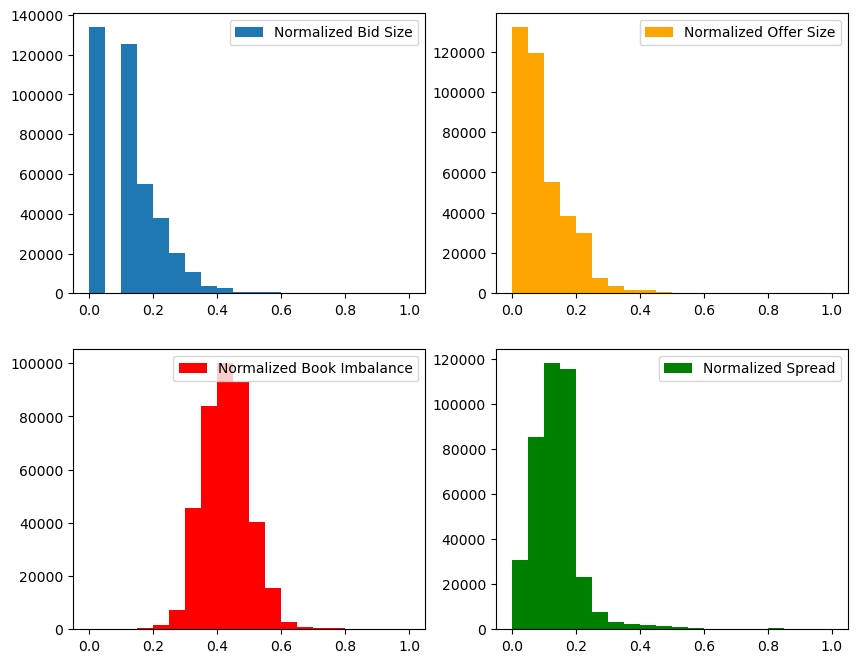

In [45]:
fig,ax=plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(normalized_bidsize,label='Normalized Bid Size',bins=20)
ax[0][1].hist(normalized_offersize, label='Normalized Offer Size',color='orange',bins=20)
ax[1][0].hist(normalized_bookimbalance,label='Normalized Book Imbalance',color='red',bins=20)
ax[1][1].hist(normalized_spread, label='Normalized Spread',color='green',bins=20)

ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend()
ax[1][1].legend()


In [46]:
features['Bid_Size']=normalized_bidsize
features['Offer_Size']=normalized_offersize
features['OB_IB']=normalized_bookimbalance
features['spread']=normalized_spread


features.to_csv('data/features.csv')
features

,Bid_Size,Offer_Size,spread,OB_IB
2020-01-02 09:30:00.134062,0.000000,0.000000,0.342176,0.430041
2020-01-02 09:30:00.134336,0.000000,0.000000,0.330141,0.430041
2020-01-02 09:30:00.134532,0.000000,0.091578,0.372143,0.482240
2020-01-02 09:30:00.136081,0.000000,0.000000,0.336317,0.430041
2020-01-02 09:30:00.234474,0.000000,0.000000,0.380608,0.430041
...,...,...,...,...
2020-01-02 19:59:43.952528,0.121383,0.000000,0.457722,0.377841
2020-01-02 19:59:52.610437,0.121383,0.000000,0.421348,0.377841
2020-01-02 19:59:52.611152,0.121383,0.000000,0.457722,0.377841
2020-01-02 19:59:52.611817,0.000000,0.236727,0.501939,0.564974


### Testing Set

In [8]:
outcomes=simple_quotes[['spread_state']].copy()
outcomes.to_csv('data/outcomes.csv')
outcomes

,spread_state
2020-01-02 09:30:00.134062,0
2020-01-02 09:30:00.134336,-1
2020-01-02 09:30:00.134532,1
2020-01-02 09:30:00.136081,-1
2020-01-02 09:30:00.234474,1
...,...
2020-01-02 19:59:43.952528,1
2020-01-02 19:59:52.610437,-1
2020-01-02 19:59:52.611152,1
2020-01-02 19:59:52.611817,1
